# Определение перспективного тарифа для телеком компании.

Предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Загрузка данных и изучение общеё информации

In [145]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.options.mode.chained_assignment = None

In [146]:
# чтение файла
data_calls = pd.read_csv("/datasets/calls.csv", sep=",")
data_internet = pd.read_csv("/datasets/internet.csv", sep=",")
data_messages = pd.read_csv("/datasets/messages.csv", sep=",")
data_tariffs = pd.read_csv("/datasets/tariffs.csv", sep=",")
data_users = pd.read_csv("/datasets/users.csv", sep=",")


In [147]:
# получение первых 5 строк таблицы
data_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [148]:
# получение общей информации о данных в таблице
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [149]:
# получение первых 5 строк таблицы
data_internet.head(5)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [150]:
# получение общей информации о данных в таблице
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [151]:
# получение первых 5 строк таблицы
data_messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [152]:
# получение общей информации о данных в таблице
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [153]:
# получение первых 5 строк таблицы
data_tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [154]:
# получение первых 5 строк таблицы
data_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [155]:
# получение общей информации о данных в таблице
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Описание данных

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

На первый взгляд данные готовы к работе, стоит поменять только тип данных в столбце с датой. Пропуски наблюдается только в столбе 'churn_date', но это обоснованно тем что клиент действующий.

### Шаг 2. Подготовка данных

In [156]:
# поменяю тип данных в столбце с датой на формат даты
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d %H:%M')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d %H:%M')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d %H:%M')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d %H:%M')

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

Поэтому округлим время разговора в data_calls['duration'] и поменяем формат на int

In [157]:
# округление и изменение типа данных
data_calls['duration'] = data_calls['duration'].apply(np.ceil).astype('int')
data_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


В выгрузке по совершенным звонкам наблюдаются звонки с длительность 0, вероятнее всего системя записывает высе попытки звонков, даже если разговор не начался, так как минуты при таких звонках не расходуются удалим данные с длительностью звонка 0

In [158]:
# срез данных 
data_calls = data_calls.query('duration > 0')

Для дальнейшего анализа данных необходимо выделить из столбца с датой номера месяцев, чтобы собрать статистику по месяцам.

In [159]:
# добавление нового столбца в таблицах
data_calls['month_number'] = data_calls['call_date'].dt.month
data_messages['month_number'] = data_messages['message_date'].dt.month
data_internet['month_number'] = data_internet['session_date'].dt.month

#data_calls['month_number'].value_counts()

In [160]:
# объединим данные со звонками и данные о пользователях и 
# созданим сводкую таблице по колличеству звонков и сумме потраченных минут
data_calls = data_calls.merge(data_users, on='user_id')
calls_pivot = (data_calls
                   .pivot_table(index=['user_id', 'month_number', 'tariff'],
                                values='duration', 
                                aggfunc=['count', 'sum']
                               )
              )
calls_pivot.columns = ['count_colls', 'duration_sum']

# созданим сводную таблицу по потраченным СМС
message_pivot = (data_messages
                   .pivot_table(index=['user_id', 'month_number'],
                                values='message_date', 
                                aggfunc='count'
                               )
                )
message_pivot.columns = ['message_count']

# создадим сводную тамблицу по потраченнуму трафику
internet_pivot = (data_internet
                   .pivot_table(index=['user_id', 'month_number'],
                                values='mb_used', 
                                aggfunc='sum'
                               )
                )
internet_pivot.columns = ['traffik_mb']

In [161]:
# объединим ранее полученные таблицы для дальнешей аналитики
final_pivot = calls_pivot.join(message_pivot)
final_pivot = final_pivot.join(internet_pivot)

# заменим пропуски на 0
final_pivot['message_count'] = final_pivot['message_count'].fillna(0).astype('int')

# вывод первых 5 строк
final_pivot.head()

count_colls  duration_sum  message_count  \
user_id month_number tariff                                             
1000    5            ultra            17           159             22   
        6            ultra            28           172             60   
        7            ultra            41           340             75   
        8            ultra            42           408             81   
        9            ultra            46           466             57   

                             traffik_mb  
user_id month_number tariff              
1000    5            ultra      2253.49  
        6            ultra     23233.77  
        7            ultra     14003.64  
        8            ultra     14055.93  
        9            ultra     14568.91

Посчитаем помесячную выручку с каждого пользователя для этого напишеи функцию и применим ее к ранее полученной таблице.

In [162]:
# функция для подсчета выручки
def income(final_pivot):
    total_income_ultra = data_tariffs.at[1, 'rub_monthly_fee'] # базовая стоимость ТП Ultra
    total_income_smart = data_tariffs.at[0, 'rub_monthly_fee'] # базовая стоимость ТП Smart
    
    tariff = final_pivot['tariff'] # значение тарифа
    duration_sum = final_pivot['duration_sum'] # значение суммы миенут
    message_count = final_pivot['message_count'] # значение колличества СМС
    traffik_mb = final_pivot['traffik_mb'] # сумма потреченого трафика
    
    rub_per_minute_ultra = data_tariffs.at[1, 'rub_per_minute'] # стоимость 1 минуты Ультра
    rub_per_message_ultra = data_tariffs.at[1, 'rub_per_message'] # стоимость 1 СМС Ультра
    rub_per_gb_ultra = data_tariffs.at[1, 'rub_per_gb'] # стоимость 1 Гб ультра
    
    rub_per_minute_smart = data_tariffs.at[0, 'rub_per_minute'] # стоимость 1 минуты смарт
    rub_per_message_smart = data_tariffs.at[0, 'rub_per_message']  # стоимость 1 СМС смарт
    rub_per_gb_smart = data_tariffs.at[0, 'rub_per_gb']     # стоимость 1 Гб смарт
    
    gb = 1024 # кол-во Mb в Gb
    # подсчет выручки для тарифов Ultra
    if tariff == 'ultra':
        if duration_sum > data_tariffs.at[1, 'minutes_included']:
            duration_income = (duration_sum - data_tariffs.at[1, 'minutes_included']) * rub_per_minute_ultra
            total_income_ultra += duration_income
        if message_count > data_tariffs.at[1, 'messages_included']:
            message_income = (message_count - data_tariffs.at[1, 'messages_included']) * rub_per_message_ultra
            total_income_ultra += message_income
        if traffik_mb > data_tariffs.at[1, 'mg_per_month_included']:
            traffik_income = math.ceil((traffik_mb - data_tariffs.at[1, 'mg_per_month_included']) / gb) * rub_per_gb_ultra
            total_income_ultra += traffik_income
        return total_income_ultra
     # подсчет выручки для тарифов Smart    
    if tariff == 'smart':
        if duration_sum > data_tariffs.at[0, 'minutes_included']:
            duration_income = (duration_sum - data_tariffs.at[0, 'minutes_included']) * rub_per_minute_smart
            total_income_smart += duration_income
        if message_count > data_tariffs.at[0, 'messages_included']:
            message_income = (message_count - data_tariffs.at[0, 'messages_included']) * rub_per_message_smart
            total_income_smart += message_income
        if traffik_mb > data_tariffs.at[0, 'mg_per_month_included']:
            traffik_income = math.ceil((traffik_mb - data_tariffs.at[0, 'mg_per_month_included']) / gb) * rub_per_gb_smart
            total_income_smart += traffik_income
              
        return total_income_smart

    
# применим функцию для ранее полученной таблицы    
final_pivot = final_pivot.reset_index()
final_pivot['total_income'] = final_pivot.apply(income, axis=1)
final_pivot

,user_id,month_number,tariff,count_colls,duration_sum,message_count,traffik_mb,total_income
0,1000,5,ultra,17,159,22,2253.49,1950
1,1000,6,ultra,28,172,60,23233.77,1950
2,1000,7,ultra,41,340,75,14003.64,1950
3,1000,8,ultra,42,408,81,14055.93,1950
4,1000,9,ultra,46,466,57,14568.91,1950
...,...,...,...,...,...,...,...,...
3163,1498,10,smart,30,247,42,20579.36,1750
3164,1499,9,smart,8,70,11,1845.75,550
3165,1499,10,smart,44,449,48,17788.51,1150
3166,1499,11,smart,62,612,59,17963.31,1513


---
### Вывод:

Из исходных таблиц я получил 3 сводные таблицы с коллическом и продолжительностью звонком, коллическов СМС и потраченного трафика в разбикве по месяцам. В ходе работы в таблице появились стороки в столбце с колличеством СМС в которых не было данных. В этих строках я заменил значения на 0, так в эти месяцы не отправлялись СМС.

Эти таблицы я соедил в одну и на основание полученных данных посчитал помесечную выручку по каждому клиенту

---

### Шаг 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Для этого посчитаем:
- среднее количество, 
- дисперсию,
- стандартное отклонение.

Построем гистограммы и опишем распределения. 

In [163]:
# сделенм срез данных для каждого тарифа
data_smart = final_pivot.query('tariff == "smart"')
data_smart.describe()

,user_id,month_number,count_colls,duration_sum,message_count,traffik_mb,total_income
count,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,2220.000000,2221.000000
mean,1245.789734,8.349392,47.116614,419.440342,33.392166,16217.960284,1291.108059
std,145.853596,2.917705,20.887092,188.992403,28.270233,5867.577983,819.319381
min,1001.000000,1.000000,1.000000,2.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,32.000000,285.000000,10.000000,12663.052500,550.000000
50%,1239.000000,9.000000,48.000000,423.000000,28.000000,16505.475000,1030.000000
75%,1376.000000,11.000000,61.000000,546.000000,51.000000,20046.935000,1750.000000
max,1499.000000,12.000000,162.000000,1435.000000,143.000000,38552.450000,6770.000000


In [164]:
data_ultra = final_pivot.query('tariff == "ultra"')
data_ultra.describe()

,user_id,month_number,count_colls,duration_sum,message_count,traffik_mb,total_income
count,947.000000,947.000000,947.000000,947.000000,947.000000,937.000000,947.000000
mean,1264.817318,8.242872,61.613516,547.755016,48.759240,19679.388324,2071.488912
std,140.706956,2.882502,34.189197,305.513385,46.601785,9978.779388,380.142958
min,1000.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1950.000000
25%,1148.000000,6.000000,35.000000,311.000000,5.000000,11873.280000,1950.000000
50%,1281.000000,9.000000,61.000000,529.000000,39.000000,19423.760000,1950.000000
75%,1381.000000,11.000000,84.000000,758.000000,78.500000,26927.850000,1950.000000
max,1495.000000,12.000000,190.000000,1673.000000,224.000000,49745.690000,4800.000000


In [165]:
# посчитаем средние показатели в развивке по месяцам по каждому тарифу
month_pivot = (final_pivot
                   .pivot_table(index='month_number',
                                columns='tariff', 
                                aggfunc={'duration_sum':'mean', 'message_count':'mean', 'traffik_mb':'mean'}
                               )
              )

month_pivot.style.format("{:.0f}")

In [166]:
# посчитаем средние раскходы по каждому тарицу в целом 
tariff_pivot = (final_pivot
                   .pivot_table(index='tariff',                                 
                                aggfunc={'duration_sum':'mean', 'message_count':'mean', 'traffik_mb':'mean'}
                               )
              )

tariff_pivot.style.format("{:.0f}")

,duration_sum,message_count,traffik_mb
tariff,,,
smart,419,33,16218
ultra,548,49,19679


In [167]:
# рассчет дисперсии для тарифов Смарт
var_smart_dur = np.var(data_smart['duration_sum'], ddof=1)
var_smart_mess = np.var(data_smart['message_count'], ddof=1)
var_smart_traf = np.var(data_smart['traffik_mb'], ddof=1)
print('Дисперсия по тарифам смарт:', var_smart_dur, var_smart_mess, var_smart_traf)

# рассчет дисперсии для тарифов Ультра
var_ultra_dur = np.var(data_ultra['duration_sum'], ddof=1)
var_ultra_mess = np.var(data_ultra['message_count'], ddof=1)
var_ultra_traf = np.var(data_ultra['traffik_mb'], ddof=1)
print('Дисперсия по тарифам ультра:', var_ultra_dur, var_ultra_mess, var_ultra_traf)

Дисперсия по тарифам смарт: 35718.128533936906 799.2060467040657 34428471.39120519
Дисперсия по тарифам ультра: 93338.42829141095 2171.7263283853986 99576038.06548022


In [168]:
# рассчет стандартного отклонения для тарифов Смарт
std_smart_dur = np.std(data_smart[['duration_sum']], ddof=1)
std_smart_mess = np.std(data_smart[['message_count']], ddof=1)
std_smart_traf = np.std(data_smart[['traffik_mb']], ddof=1)

# рассчет стандартного отклонения для тарифов Ультра
std_ultra_dur = np.std(data_ultra[['duration_sum']], ddof=1)
std_ultra_mess = np.std(data_ultra[['message_count']], ddof=1)
std_ultra_traf = np.std(data_ultra[['traffik_mb']], ddof=1)

In [169]:
# функция для построения 2 графиков
def boxprint(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    colum.hist(bins=bins, range=((q1-3*iqr), (q3+3*iqr)))
    plt.show()
    sns.boxplot(x=colum, color='red')
    

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: duration_sum, dtype: float64


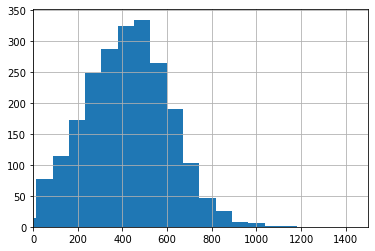

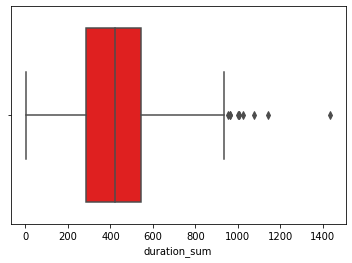

In [170]:
plt.xlim(0, 1500)
boxprint(data_smart['duration_sum'], 25)

Распредение данных по сумме звоноков нормальное 75% клиентом почти не превышают пакет минут. Оставшиеся приносят дополнительный доход

count    2221.000000
mean       33.392166
std        28.270233
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_count, dtype: float64


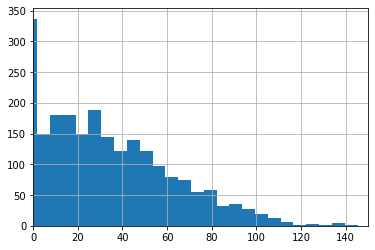

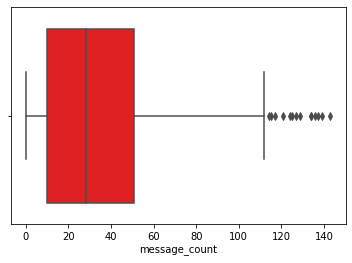

In [171]:
plt.xlim(0, 150)
boxprint(data_smart['message_count'], 50)

75% клиентов транят 51 СМС при этом в пакете 50. 

count     2220.000000
mean     16217.960284
std       5867.577983
min          0.000000
25%      12663.052500
50%      16505.475000
75%      20046.935000
max      38552.450000
Name: traffik_mb, dtype: float64


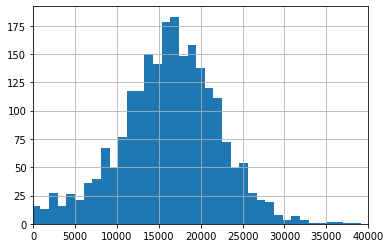

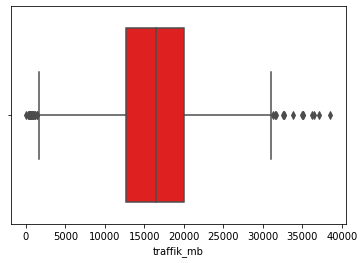

In [172]:
plt.xlim(0, 40000)
boxprint(data_smart['traffik_mb'], 50)

Данные по трафику более интересны половина клиентов из выборки превышает пакет Мб из тарифа, данные клиенты приносят значительный объем дополнительного дохода.

count     947.000000
mean      547.755016
std       305.513385
min         1.000000
25%       311.000000
50%       529.000000
75%       758.000000
max      1673.000000
Name: duration_sum, dtype: float64


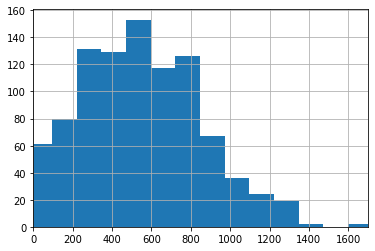

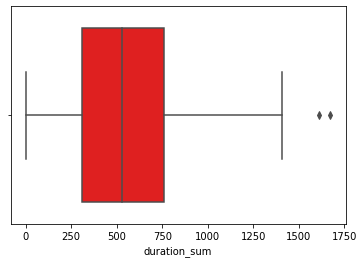

In [173]:
plt.xlim(0, 1700)
boxprint(data_ultra['duration_sum'], 25)

Пакет минут по тарифу Ультра ни один клиенты не выговариает, есть единичные случаи при которых колличество минут более 1500, при этом лимит 3000

count    947.000000
mean      48.759240
std       46.601785
min        0.000000
25%        5.000000
50%       39.000000
75%       78.500000
max      224.000000
Name: message_count, dtype: float64


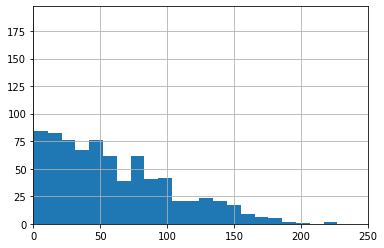

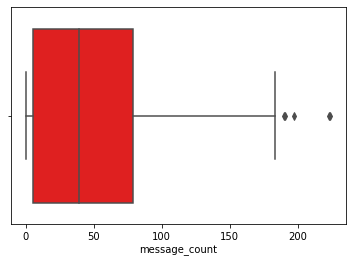

In [174]:
plt.xlim(0, 250)
boxprint(data_ultra['message_count'], 50)

Пакет СМС по тарифу Ультра ни один клиент не выговариает, есть единичные случаи при которых колличество минут более 200, при этом лимит 1000

count      937.000000
mean     19679.388324
std       9978.779388
min          0.000000
25%      11873.280000
50%      19423.760000
75%      26927.850000
max      49745.690000
Name: traffik_mb, dtype: float64


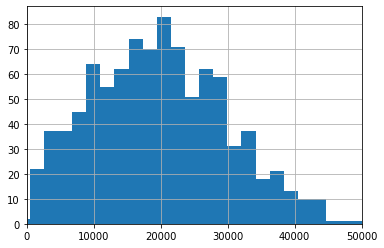

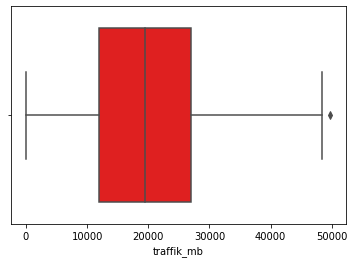

In [175]:
plt.xlim(0, 50000)
boxprint(data_ultra['traffik_mb'], 50)

75% процентам клиентов хватает пакета Мб не большая часть приносить дополнительный доход за счет дополнительного трафика.

In [176]:
data_tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


---

### Вывод:

Проанализировва данные по выборке клиентовможно сделать служеющие выводы по тарифам:

##### Ультра:
Дополнительный доход поступает за счет дополнительного трафика, 75% не расходуют выделенный пакет Мб, пакеты минут и СМС не расходуются.


##### Смарт:
- 75% клиентом почти не превышают пакет минут. Оставшиеся приносят дополнительный доход.
- 75% клиентов транят 51 СМС при этом в пакете 50. 
- Данные по трафику более интересны половина клиентов из выборки превышает пакет Мб из тарифа, данные клиенты приносят значительный объем дополнительного дохода.

Можно сделать вывовды что клиенты на тарифах смарт принросят больше дополнительного дохожда за счет продажи дополнительных пакетов.

---

### Шаг 4. Проверка гипотез

In [177]:
# функция для добавления столба с категорией города
def city_cat_ult(data_ult_fin):
    if data_ult_fin['city'] == 'Москва':
        return 'Москва'
    if data_ult_fin['city'] != 'Москва':
        return 'Другой регион'
    
def city_cat_smt(data_smt_fin):
    if data_smt_fin['city'] == 'Москва':
        return 'Москва'
    if data_smt_fin['city'] != 'Москва':
        return 'Другой регион'

In [178]:
# применим функции и добавим столбец с категорией города в таблицы
data_ult_fin = data_ultra.merge(data_users, on='user_id')
data_ult_fin['city_category'] = data_ult_fin.apply(city_cat_ult, axis=1)

data_smt_fin = data_smart.merge(data_users, on='user_id')
data_smt_fin['city_category'] = data_smt_fin.apply(city_cat_smt, axis=1)


In [179]:
# расчет средей выручки по тарифам
mean_total_income_smart = data_smt_fin['total_income'].mean()
print('Средня выручка по тарифу Смарт:', mean_total_income_smart)

mean_total_income_ultra = data_ult_fin['total_income'].mean()
print('Средня выручка по тарифу Ультра:', mean_total_income_ultra)

Средня выручка по тарифу Смарт: 1291.108059432688
Средня выручка по тарифу Ультра: 2071.4889123548046


In [180]:
total_income = final_pivot.merge(data_users, on='user_id')
total_income['city_category'] = total_income.apply(city_cat_smt, axis=1)

total_income_moskow = total_income.query('city_category == "Москва"')
mean_total_income_moskow = total_income_moskow['total_income'].mean()
print('Средня выручка по пользователям в Москве:', mean_total_income_moskow)

total_income_um_moskow = total_income.query('city_category != "Москва"')
mean_total_income__um_moskow = total_income_um_moskow['total_income'].mean()
print('Средня выручка по пользователям в других регионах:', mean_total_income__um_moskow)

Средня выручка по пользователям в Москве: 1546.0524590163934
Средня выручка по пользователям в других регионах: 1519.217748240813


### Гипотеза о равенсве средних по городам

Данные представлены 2 выборками сформируе гипотезу о равенсве средних по выручке в зависисмости от населенного пункта.
Уровень значимости возьмем на уровне 5%

- Н0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов 
- Н1: отличаются

In [187]:
# Проверка гипотезы средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
alpha = .05

results = st.ttest_ind(
    total_income_moskow['total_income'], 
    total_income_um_moskow['total_income']
)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.45718519583645034
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу от сюда можно сделать вывод, что доход по тарифам не отличается в зависимости от региона.

### Гипотеза о равенсве средних по тарифам

Данные представлены 2 выборками сформируе гипотезу о равенсве средних по выручке в зависисмости от Тарифа.
Уровень значимости возьмем на уровне 5%

- Н0: средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.
- Н1: отличаются

In [182]:
# Проверка гипотезы средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
alpha = .05

results = st.ttest_ind(
    data_smt_fin['total_income'], 
    data_ult_fin['total_income']
)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.145017201938894e-155
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу поскольку разница очень большая.
Можно сделать вывод, что доход по тарифам отличается, Что ожмдаемо так как базовая стоимость по тарифцу Ультра 3,5 раза дороже Смарта. 

---
### Вывод:

На данном этапе подготовили данные для проверки 2 гипотез.

#### Гипотеза о равенсве средних по городам
Не получилось отвергнуть нулевую гипотезу от сюда можно сделать вывод, что доход по тарифам не отличается в зависимости от региона.

#### Гипотеза о равенсве средних по тарифам
Отвергаем нулевую гипотезу поскольку разница очень большая. Можно сделать вывод, что доход по тарифам отличается, Что ожмдаемо так как базовая стоимость по тарифцу Ультра 3,5 раза дороже Смарта.

От сюда можно сделать вывод, что поведение клиента отличается только в рамках параметра своего тарифа

---

### Шаг 5. Общий вывод

Из имеющихся данных сложно сделать выводы какой тариф лучше.

Для мобильного оператора лучше Ультра так как приносит больше дохода, но для клиентов на тарифе Смарта значительно больше. При этом они приносят больше дохода чем базовая стоимость тарифа, за счет дополнительных пакетов услуг.

Средняя выручка по тарифу Смарта 1291, что меньше чем стоимость тарифа Ультра даже с учетом дополнительныз пактов услуг.
От сюда можно сделать вывод, что клиентам выходнее пользоваться Смартом так как даже если превывать выделенные пакеты по тарифу, то они всё-равно будут платить меньше чем на Ультра.

Операторы выгодно продавать Ультра, так как они продают сразу 3 000 минут и 1 000 СМС которые клиентры не расходуют.


### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] открыт файл
- [x] файлы изучены (выведены первые строки, метод info())
- [x] Приведите данные к нужным типам
- [x] Найдите и исправьте ошибки в данных
- [x] количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x] количество отправленных сообщений по месяцам;
- [x] объем израсходованного интернет-трафика по месяцам;
- [x] помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
- [x] Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.
- [x] средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- [x] средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
- [x] общие выводы